# All

In [1]:
# Standard libraries
import warnings
warnings.filterwarnings("ignore")
import random
import numpy as np
import tensorflow as tf
import pandas as pd
! pip install optuna
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load dataset
import gdown
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"
output_file = "downloaded_file.xlsx"
gdown.download(download_url, output=output_file, quiet=False)

df = pd.read_excel(output_file)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.set_index('Date', inplace=True)
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
target_column = "Inflation"
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Deep learning
import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = []

for lag in range(1, 10):
    print(f"\nProcessing lag = {lag}...")

    # Sequence generation
    X, y = create_sequences(df[target_column].values, lag)
    split_index = int(len(X) * 0.9)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    def create_model(trial, input_shape):
        model = Sequential()
        model.add(Conv1D(
            filters=trial.suggest_int('filters', 32, 128),
            kernel_size=trial.suggest_int('kernel_size', 1, lag),
            activation='relu',
            input_shape=input_shape))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(optimizer=Adam(
            learning_rate=trial.suggest_float('lr', 1e-4, 1e-2, log=True)),
            loss='mse')
        return model

    def objective(trial):
        tscv = TimeSeriesSplit(n_splits=3)
        val_losses = []
        for train_idx, val_idx in tscv.split(X_train):
            X_t, X_v = X_train[train_idx], X_train[val_idx]
            y_t, y_v = y_train[train_idx], y_train[val_idx]

            model = create_model(trial, X_train.shape[1:])
            model.fit(X_t, y_t,
                      epochs=trial.suggest_int('epochs', 10, 50),
                      verbose=0,
                      batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

            val_loss = model.evaluate(X_v, y_v, verbose=0)
            val_losses.append(val_loss)
        return np.mean(val_losses)

    # Optuna study
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=30)

    best_params = study.best_trial.params

    # Final model training
    model = Sequential()
    model.add(Conv1D(filters=best_params['filters'],
                     kernel_size=best_params['kernel_size'],
                     activation='relu',
                     input_shape=X_train.shape[1:]))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=best_params['lr']),
                  loss='mse')
    model.fit(X_train, y_train,
              epochs=best_params['epochs'],
              batch_size=best_params['batch_size'],
              verbose=0)

    # Evaluation
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
    r2 = r2_score(y_test_inv, y_pred_inv)

    results.append({
        "Lag": lag,
        "Best Parameters": best_params,
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "MAPE": mape,
        "R²": r2
    })

# Save results to Excel
results_df = pd.DataFrame(results)
results_df.to_excel("CNN_Lag_Performance_Results.xlsx", index=False)
print("\n✅ All lags processed. Results saved to 'CNN_Lag_Performance_Results.xlsx'")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.9 MB/s eta 0:00:00


Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 17.6MB/s]
[I 2025-06-02 11:17:54,822] A new study created in memory with name: no-name-7ec25ded-d1af-48a6-ae32-3ff60e393d18



Processing lag = 1...


[I 2025-06-02 11:18:06,387] Trial 0 finished with value: 0.0009922955456810694 and parameters: {'filters': 68, 'kernel_size': 1, 'lr': 0.007969454818643935, 'epochs': 40, 'batch_size': 8}. Best is trial 0 with value: 0.0009922955456810694.
[I 2025-06-02 11:18:13,251] Trial 1 finished with value: 0.0014993543542611103 and parameters: {'filters': 37, 'kernel_size': 1, 'lr': 0.005399484409787433, 'epochs': 34, 'batch_size': 32}. Best is trial 0 with value: 0.0009922955456810694.
[I 2025-06-02 11:18:17,394] Trial 2 finished with value: 0.008811166238350173 and parameters: {'filters': 112, 'kernel_size': 1, 'lr': 0.00026587543983272726, 'epochs': 17, 'batch_size': 32}. Best is trial 0 with value: 0.0009922955456810694.
[I 2025-06-02 11:18:24,084] Trial 3 finished with value: 0.0074224772009377675 and parameters: {'filters': 73, 'kernel_size': 1, 'lr': 0.0003823475224675188, 'epochs': 35, 'batch_size': 32}. Best is trial 0 with value: 0.0009922955456810694.
[I 2025-06-02 11:18:28,981] Trial 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-06-02 11:21:56,133] A new study created in memory with name: no-name-069d96cf-ae71-42e2-916d-8654c0c10dba



Processing lag = 2...


[I 2025-06-02 11:22:04,281] Trial 0 finished with value: 0.0011528398705801617 and parameters: {'filters': 68, 'kernel_size': 2, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0011528398705801617.
[I 2025-06-02 11:22:07,688] Trial 1 finished with value: 0.0019050341312928747 and parameters: {'filters': 116, 'kernel_size': 2, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0011528398705801617.
[I 2025-06-02 11:22:14,556] Trial 2 finished with value: 0.007340384569639961 and parameters: {'filters': 49, 'kernel_size': 1, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0011528398705801617.
[I 2025-06-02 11:22:20,930] Trial 3 finished with value: 0.0031699159493048987 and parameters: {'filters': 45, 'kernel_size': 1, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0011528398705801617.
[I 2025-06-02 11:22:25,663] Trial 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2025-06-02 11:25:59,046] A new study created in memory with name: no-name-50f7f62e-7677-4cbc-b887-84f86d24c9d5



Processing lag = 3...


[I 2025-06-02 11:26:06,863] Trial 0 finished with value: 0.0015084827415800344 and parameters: {'filters': 68, 'kernel_size': 3, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0015084827415800344.
[I 2025-06-02 11:26:10,975] Trial 1 finished with value: 0.0029754152928944677 and parameters: {'filters': 116, 'kernel_size': 2, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0015084827415800344.
[I 2025-06-02 11:26:17,158] Trial 2 finished with value: 0.005909701692871749 and parameters: {'filters': 49, 'kernel_size': 1, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0015084827415800344.
[I 2025-06-02 11:26:24,100] Trial 3 finished with value: 0.0037386257705899575 and parameters: {'filters': 45, 'kernel_size': 1, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0015084827415800344.
[I 2025-06-02 11:26:28,480] Trial 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-06-02 11:30:04,956] A new study created in memory with name: no-name-1f359796-18a5-49b6-ae66-0bd26ee94e12



Processing lag = 4...


[I 2025-06-02 11:30:12,617] Trial 0 finished with value: 0.0011705132201313972 and parameters: {'filters': 68, 'kernel_size': 4, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0011705132201313972.
[I 2025-06-02 11:30:16,765] Trial 1 finished with value: 0.00311851070728153 and parameters: {'filters': 116, 'kernel_size': 3, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0011705132201313972.
[I 2025-06-02 11:30:23,332] Trial 2 finished with value: 0.010800680068011085 and parameters: {'filters': 49, 'kernel_size': 1, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0011705132201313972.
[I 2025-06-02 11:30:30,146] Trial 3 finished with value: 0.0029725841401765742 and parameters: {'filters': 45, 'kernel_size': 2, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0011705132201313972.
[I 2025-06-02 11:30:34,527] Trial 4 f

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[I 2025-06-02 11:34:09,185] A new study created in memory with name: no-name-50267da7-5e28-4064-bac8-76acb5464eff



Processing lag = 5...


[I 2025-06-02 11:34:16,932] Trial 0 finished with value: 0.0010087729218260695 and parameters: {'filters': 68, 'kernel_size': 5, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0010087729218260695.
[I 2025-06-02 11:34:20,668] Trial 1 finished with value: 0.0023805702997681997 and parameters: {'filters': 116, 'kernel_size': 4, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0010087729218260695.
[I 2025-06-02 11:34:30,324] Trial 2 finished with value: 0.007866515855615338 and parameters: {'filters': 49, 'kernel_size': 1, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0010087729218260695.
[I 2025-06-02 11:34:37,455] Trial 3 finished with value: 0.0024021217929354557 and parameters: {'filters': 45, 'kernel_size': 2, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0010087729218260695.
[I 2025-06-02 11:34:43,845] Trial 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


[I 2025-06-02 11:38:38,715] A new study created in memory with name: no-name-1d0b543c-6d88-49b6-bb1d-a186a39c5285



Processing lag = 6...


[I 2025-06-02 11:38:47,671] Trial 0 finished with value: 0.001254707477831592 and parameters: {'filters': 68, 'kernel_size': 6, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.001254707477831592.
[I 2025-06-02 11:38:52,143] Trial 1 finished with value: 0.002082561705416689 and parameters: {'filters': 116, 'kernel_size': 4, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.001254707477831592.
[I 2025-06-02 11:38:58,321] Trial 2 finished with value: 0.007285374643591543 and parameters: {'filters': 49, 'kernel_size': 2, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.001254707477831592.
[I 2025-06-02 11:39:05,732] Trial 3 finished with value: 0.0036035726661793888 and parameters: {'filters': 45, 'kernel_size': 2, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.001254707477831592.
[I 2025-06-02 11:39:10,541] Trial 4 finis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-06-02 11:43:02,769] A new study created in memory with name: no-name-fc180ee3-f68c-4a64-a011-f82ed80d3371



Processing lag = 7...


[I 2025-06-02 11:43:11,004] Trial 0 finished with value: 0.0012752100883517414 and parameters: {'filters': 68, 'kernel_size': 7, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0012752100883517414.
[I 2025-06-02 11:43:14,885] Trial 1 finished with value: 0.0027641780325211585 and parameters: {'filters': 116, 'kernel_size': 5, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0012752100883517414.
[I 2025-06-02 11:43:21,870] Trial 2 finished with value: 0.006761149658511083 and parameters: {'filters': 49, 'kernel_size': 2, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0012752100883517414.
[I 2025-06-02 11:43:28,730] Trial 3 finished with value: 0.0033653322219227753 and parameters: {'filters': 45, 'kernel_size': 3, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0012752100883517414.
[I 2025-06-02 11:43:33,503] Trial 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-06-02 11:47:22,026] A new study created in memory with name: no-name-eb570744-90d3-444b-969a-89714046eb50



Processing lag = 8...


[I 2025-06-02 11:47:30,494] Trial 0 finished with value: 0.001218972179534224 and parameters: {'filters': 68, 'kernel_size': 8, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.001218972179534224.
[I 2025-06-02 11:47:34,555] Trial 1 finished with value: 0.003234386288871368 and parameters: {'filters': 116, 'kernel_size': 5, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.001218972179534224.
[I 2025-06-02 11:47:41,612] Trial 2 finished with value: 0.006945732980966568 and parameters: {'filters': 49, 'kernel_size': 2, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.001218972179534224.
[I 2025-06-02 11:47:48,234] Trial 3 finished with value: 0.004202523016526054 and parameters: {'filters': 45, 'kernel_size': 3, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.001218972179534224.
[I 2025-06-02 11:47:53,021] Trial 4 finish

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2025-06-02 11:51:36,586] A new study created in memory with name: no-name-0300c64d-3df2-453e-8ed9-94fcf4c0f496



Processing lag = 9...


[I 2025-06-02 11:51:45,389] Trial 0 finished with value: 0.0017530519786911707 and parameters: {'filters': 68, 'kernel_size': 9, 'lr': 0.0029106359131330704, 'epochs': 34, 'batch_size': 8}. Best is trial 0 with value: 0.0017530519786911707.
[I 2025-06-02 11:51:49,468] Trial 1 finished with value: 0.003412353068900605 and parameters: {'filters': 116, 'kernel_size': 6, 'lr': 0.0026070247583707684, 'epochs': 10, 'batch_size': 8}. Best is trial 0 with value: 0.0017530519786911707.
[I 2025-06-02 11:51:56,972] Trial 2 finished with value: 0.008018926988976697 and parameters: {'filters': 49, 'kernel_size': 2, 'lr': 0.0004059611610484307, 'epochs': 31, 'batch_size': 32}. Best is trial 0 with value: 0.0017530519786911707.
[I 2025-06-02 11:52:04,638] Trial 3 finished with value: 0.00380562434050565 and parameters: {'filters': 45, 'kernel_size': 3, 'lr': 0.0005404103854647331, 'epochs': 28, 'batch_size': 8}. Best is trial 0 with value: 0.0017530519786911707.
[I 2025-06-02 11:52:09,613] Trial 4 fi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

✅ All lags processed. Results saved to 'CNN_Lag_Performance_Results.xlsx'


## 1

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 4.36MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-06-02 11:55:56,674] A new study created in memory with name: no-name-76c9ef39-330f-4a25-bf44-57186f14963b
[I 2025-06-02 11:56:06,834] Trial 0 finished with value: 0.00128942991917332 and parameters: {'filters': 72, 'kernel_size': 1, 'lr': 0.006018365771428848, 'epochs': 17, 'batch_size': 32}. Best is trial 0 with value: 0.00128942991917332.
[I 2025-06-02 11:56:10,537] Trial 1 finished with value: 0.0016640384953158598 and parameters: {'filters': 122, 'kernel_size': 1, 'lr': 0.003998714266727448, 'epochs': 11, 'batch_size': 16}. Best is trial 0 with value: 0.00128942991917332.
[I 2025-06-02 11:56:14,864] Trial 2 finished with value: 0.002620268535489837 and parameters: {'filters': 112, 'kernel_size': 1, 'lr': 0.0020611017502784185, 'epochs': 13, 'batch_size': 16}. Best is trial 0 with value: 0.00128942991917332.
[I 2025-06-02 11:56:24,404] Trial 3 finished with value: 0.0009158915927400813 and parameters: {'filters': 120, 'kernel_size': 1, 'lr': 0.0041071542870878995, 'epochs': 

Best trial: {'filters': 57, 'kernel_size': 1, 'lr': 0.009790456548191134, 'epochs': 33, 'batch_size': 16}
Epoch 1/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0209  
Epoch 2/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 
Epoch 3/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016     
Epoch 4/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7887e-04 
Epoch 5/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8072e-04 
Epoch 6/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0654e-04 
Epoch 7/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1545e-04 
Epoch 8/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0245e-04 
Epoch 9/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9186e-04 
Epoch 10/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8707e-04 
Epoch 11/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8522e-04 
Epoch 12/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8561e-04 
Epoch 13/33
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

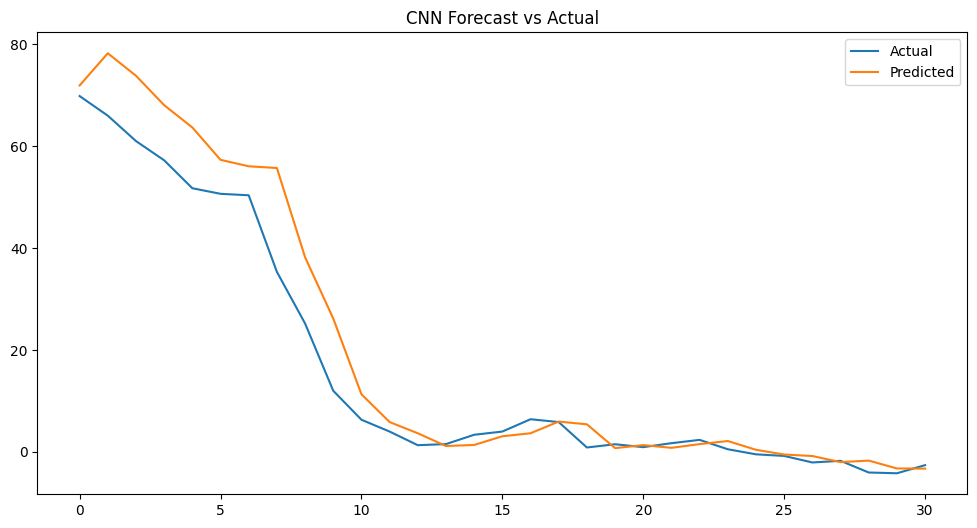

In [2]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 1  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 1), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 2

In [3]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 35.4MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


In [4]:
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 2  # Monthly data (1 year of past data to predict next month)

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)


In [6]:
split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [7]:
import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 2),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)


[I 2025-06-02 12:00:00,287] A new study created in memory with name: no-name-704f49a3-f85d-497e-b229-24a2330626f6
[I 2025-06-02 12:00:09,282] Trial 0 finished with value: 0.008250534883700311 and parameters: {'filters': 109, 'kernel_size': 1, 'lr': 0.0003262019401888197, 'epochs': 15, 'batch_size': 32}. Best is trial 0 with value: 0.008250534883700311.
[I 2025-06-02 12:00:20,378] Trial 1 finished with value: 0.0017936864751391113 and parameters: {'filters': 69, 'kernel_size': 2, 'lr': 0.0005881713349100798, 'epochs': 44, 'batch_size': 16}. Best is trial 1 with value: 0.0017936864751391113.
[I 2025-06-02 12:00:26,355] Trial 2 finished with value: 0.0030616156679267683 and parameters: {'filters': 41, 'kernel_size': 1, 'lr': 0.0018793856299980087, 'epochs': 30, 'batch_size': 32}. Best is trial 1 with value: 0.0017936864751391113.
[I 2025-06-02 12:00:36,532] Trial 3 finished with value: 0.0008517313302339365 and parameters: {'filters': 55, 'kernel_size': 2, 'lr': 0.006596946184646254, 'epo

Best trial: {'filters': 86, 'kernel_size': 1, 'lr': 0.00673852101210266, 'epochs': 35, 'batch_size': 8}


In [8]:
# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)


Epoch 1/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0094   
Epoch 2/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 
Epoch 3/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018     
Epoch 4/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 5/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 
Epoch 6/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 
Epoch 7/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013     
Epoch 8/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 9/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012
Epoch 10/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012     
Epoch 11/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 
Epoch 12/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 
Epoch 13/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010
Epoch 14/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9634e-04
Epoch 15/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss:

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Test MSE: 23.6569
Test MAE: 3.7748
Test R2: 0.9594


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
 Test MSE  : 23.6569
 Test RMSE : 4.8638
 Test MAE  : 3.7748
 Test MAPE : 105.32%
 Test R²   : 0.9594


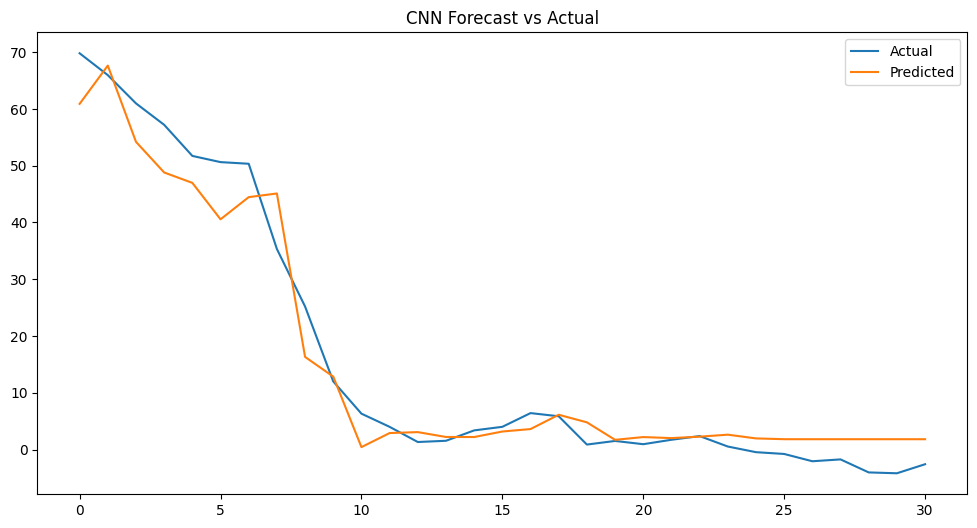

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()


## 3

## *

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 20.6MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-06-02 12:05:01,567] A new study created in memory with name: no-name-46e36c4d-72ff-4b60-8844-4e5b952765d2
[I 2025-06-02 12:05:09,499] Trial 0 finished with value: 0.015695220984828968 and parameters: {'filters': 71, 'kernel_size': 2, 'lr': 0.00012453295950202206, 'epochs': 39, 'batch_size': 32}. Best is trial 0 with value: 0.015695220984828968.
[I 2025-06-02 12:05:16,883] Trial 1 finished with value: 0.00327748647153688 and parameters: {'filters': 47, 'kernel_size': 1, 'lr': 0.0012227436266447618, 'epochs': 31, 'batch_size': 16}. Best is trial 1 with value: 0.00327748647153688.
[I 2025-06-02 12:05:26,629] Trial 2 finished with value: 0.003133446521436175 and parameters: {'filters': 41, 'kernel_size': 2, 'lr': 0.0008914691153874366, 'epochs': 43, 'batch_size': 16}. Best is trial 2 with value: 0.003133446521436175.
[I 2025-06-02 12:05:35,579] Trial 3 finished with value: 0.0038868249393999577 and parameters: {'filters': 56, 'kernel_size': 1, 'lr': 0.00035008020807100065, 'epochs'

Best trial: {'filters': 84, 'kernel_size': 2, 'lr': 0.009903874007549019, 'epochs': 22, 'batch_size': 8}
Epoch 1/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134   
Epoch 2/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 
Epoch 3/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020     
Epoch 4/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017     
Epoch 5/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014     
Epoch 6/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011     
Epoch 7/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7172e-04 
Epoch 8/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3394e-04 
Epoch 9/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9038e-04 
Epoch 10/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6918e-04 
Epoch 11/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6222e-04 
Epoch 12/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5450e-04 
Epoch 13/22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

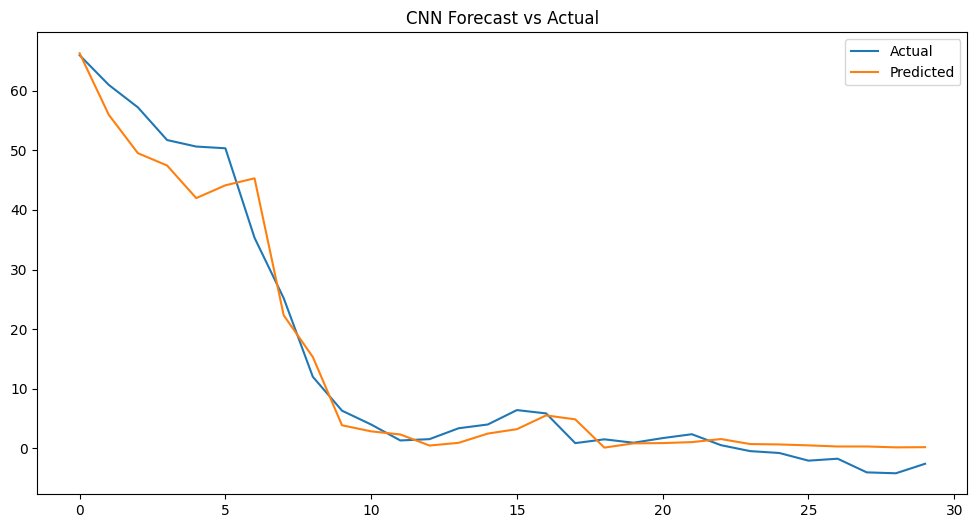

In [12]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()


# Create a copy of the data
df = data.copy()

# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 3  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 3), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 4

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 6.84MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-06-02 12:08:54,656] A new study created in memory with name: no-name-f1474650-891a-4ef1-b825-4a1ddb282067
[I 2025-06-02 12:09:00,346] Trial 0 finished with value: 0.018938881946572412 and parameters: {'filters': 35, 'kernel_size': 1, 'lr': 0.00013553596727993247, 'epochs': 20, 'batch_size': 16}. Best is trial 0 with value: 0.018938881946572412.
[I 2025-06-02 12:09:07,912] Trial 1 finished with value: 0.006635124717528622 and parameters: {'filters': 41, 'kernel_size': 1, 'lr': 0.00032841360918794884, 'epochs': 39, 'batch_size': 32}. Best is trial 1 with value: 0.006635124717528622.
[I 2025-06-02 12:09:15,883] Trial 2 finished with value: 0.004372826272932191 and parameters: {'filters': 57, 'kernel_size': 2, 'lr': 0.0006115149412980745, 'epochs': 39, 'batch_size': 32}. Best is trial 2 with value: 0.004372826272932191.
[I 2025-06-02 12:09:22,648] Trial 3 finished with value: 0.0010664319367303203 and parameters: {'filters': 80, 'kernel_size': 3, 'lr': 0.007288398730850377, 'epochs

Best trial: {'filters': 89, 'kernel_size': 2, 'lr': 0.005241942221118624, 'epochs': 50, 'batch_size': 8}
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011    
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4801e-04 
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7580e-04 
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0085e-04 
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7490e-04 
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5626e-04 
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6437e-04 
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6607e-04 
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1216e-04
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5131e-04

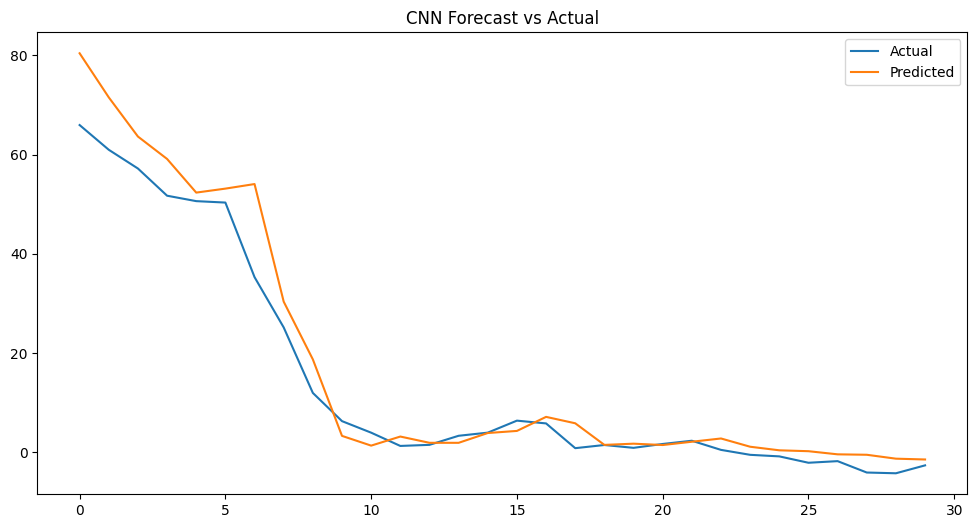

In [13]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 4  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 4), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 5

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 20.4MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-06-02 12:14:20,546] A new study created in memory with name: no-name-39efd45d-cc8f-4613-9fb0-9c31eaee9790
[I 2025-06-02 12:14:26,013] Trial 0 finished with value: 0.004069749033078551 and parameters: {'filters': 73, 'kernel_size': 1, 'lr': 0.0011855818416679805, 'epochs': 12, 'batch_size': 16}. Best is trial 0 with value: 0.004069749033078551.
[I 2025-06-02 12:14:32,802] Trial 1 finished with value: 0.001242442643463922 and parameters: {'filters': 103, 'kernel_size': 5, 'lr': 0.009989474479193716, 'epochs': 22, 'batch_size': 8}. Best is trial 1 with value: 0.001242442643463922.
[I 2025-06-02 12:14:38,296] Trial 2 finished with value: 0.008288683796611926 and parameters: {'filters': 87, 'kernel_size': 1, 'lr': 0.0005336232501844822, 'epochs': 18, 'batch_size': 32}. Best is trial 1 with value: 0.001242442643463922.
[I 2025-06-02 12:14:42,976] Trial 3 finished with value: 0.008858414056400457 and parameters: {'filters': 54, 'kernel_size': 2, 'lr': 0.00030774851695432006, 'epochs':

Best trial: {'filters': 116, 'kernel_size': 3, 'lr': 0.005169791477088659, 'epochs': 33, 'batch_size': 8}
Epoch 1/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089   
Epoch 2/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 
Epoch 3/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 
Epoch 4/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 
Epoch 5/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 
Epoch 6/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010     
Epoch 7/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7634e-04
Epoch 8/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5751e-04
Epoch 9/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6501e-04
Epoch 10/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3829e-04
Epoch 11/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1636e-04
Epoch 12/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9640e-04
Epoch 13/33
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7068e-04
Epoch

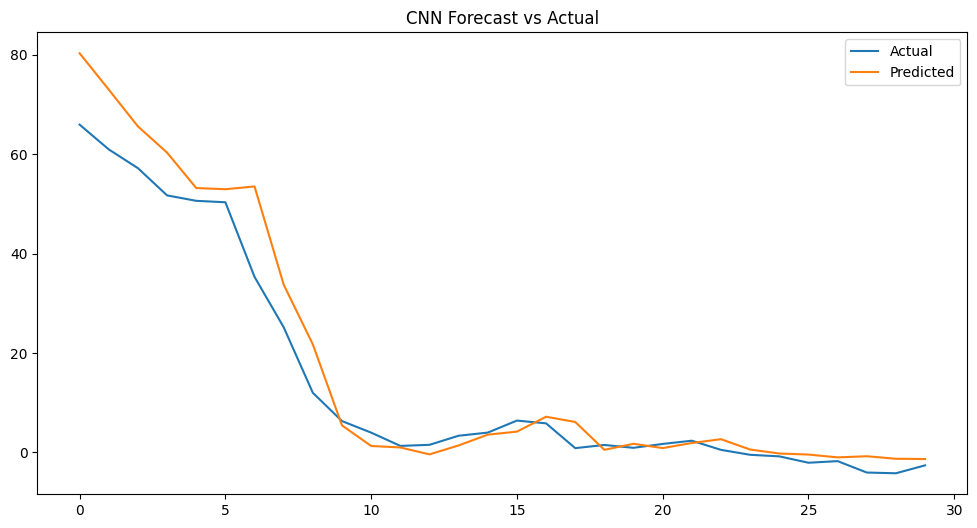

In [14]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Create a copy of the data
df = data.copy()

# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 5  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 5), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 6

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 25.4MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-06-02 12:56:21,040] A new study created in memory with name: no-name-24d073ec-6ce7-4ceb-a954-d58b42e93f40
[I 2025-06-02 12:56:31,320] Trial 0 finished with value: 0.0024451161928785345 and parameters: {'filters': 61, 'kernel_size': 4, 'lr': 0.0006797554217308215, 'epochs': 44, 'batch_size': 8}. Best is trial 0 with value: 0.0024451161928785345.
[I 2025-06-02 12:56:41,270] Trial 1 finished with value: 0.006978909291016559 and parameters: {'filters': 126, 'kernel_size': 3, 'lr': 0.00012860239730816633, 'epochs': 47, 'batch_size': 16}. Best is trial 0 with value: 0.0024451161928785345.
[I 2025-06-02 12:56:49,950] Trial 2 finished with value: 0.000988898105182064 and parameters: {'filters': 47, 'kernel_size': 5, 'lr': 0.0042139464981410715, 'epochs': 40, 'batch_size': 16}. Best is trial 2 with value: 0.000988898105182064.
[I 2025-06-02 12:56:54,571] Trial 3 finished with value: 0.0042741379390160246 and parameters: {'filters': 109, 'kernel_size': 5, 'lr': 0.002611671649879244, 'epo

Best trial: {'filters': 91, 'kernel_size': 1, 'lr': 0.009251185461710255, 'epochs': 31, 'batch_size': 8}
Epoch 1/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0115   
Epoch 2/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 
Epoch 3/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015     
Epoch 4/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013     
Epoch 5/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012     
Epoch 6/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011     
Epoch 7/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010     
Epoch 8/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4833e-04 
Epoch 9/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6553e-04 
Epoch 10/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010     
Epoch 11/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010     
Epoch 12/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4769e-04 
Epoch 13/31
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

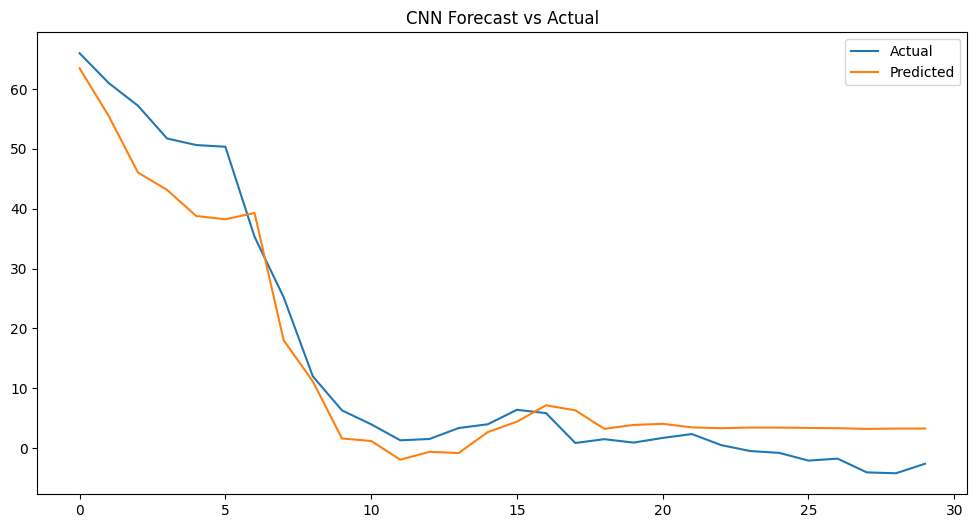

In [22]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 6  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 6), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 7

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 19.7MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-06-02 13:00:27,390] A new study created in memory with name: no-name-8daffdc5-57b6-4a39-9589-ed45e3a3dfd6
[I 2025-06-02 13:00:33,928] Trial 0 finished with value: 0.0014756172895431519 and parameters: {'filters': 74, 'kernel_size': 2, 'lr': 0.008078589654064633, 'epochs': 28, 'batch_size': 32}. Best is trial 0 with value: 0.0014756172895431519.
[I 2025-06-02 13:00:42,309] Trial 1 finished with value: 0.002977713088815411 and parameters: {'filters': 41, 'kernel_size': 3, 'lr': 0.00037989416463126894, 'epochs': 33, 'batch_size': 8}. Best is trial 0 with value: 0.0014756172895431519.
[I 2025-06-02 13:00:48,633] Trial 2 finished with value: 0.00695800098280112 and parameters: {'filters': 100, 'kernel_size': 3, 'lr': 0.0002086331750940918, 'epochs': 20, 'batch_size': 8}. Best is trial 0 with value: 0.0014756172895431519.
[I 2025-06-02 13:00:57,063] Trial 3 finished with value: 0.0011264043084035318 and parameters: {'filters': 32, 'kernel_size': 6, 'lr': 0.00858392672354735, 'epochs'

Best trial: {'filters': 53, 'kernel_size': 5, 'lr': 0.004258222564759202, 'epochs': 50, 'batch_size': 16}
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150  
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022     
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017     
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014      
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011     
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010     
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1248e-04 
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4795e-04 
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1627e-04 
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8079e-04 
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.

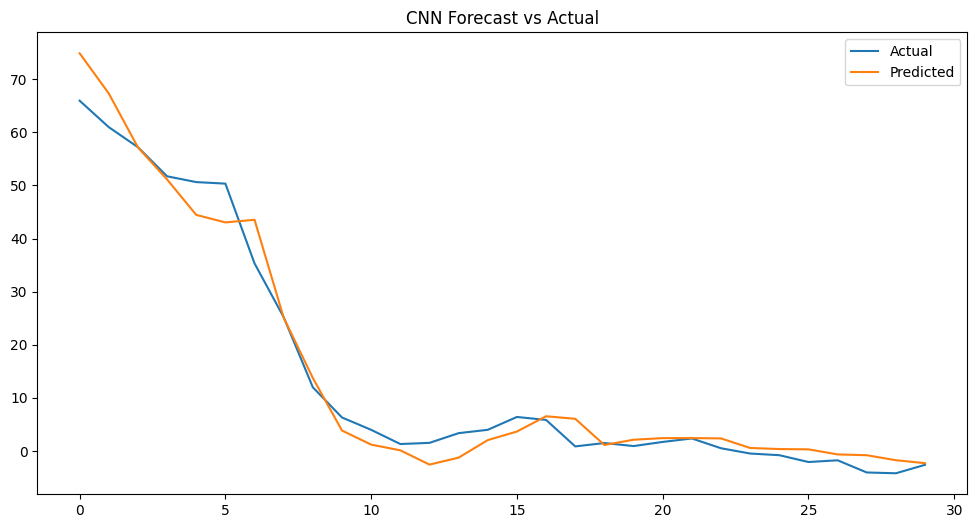

In [23]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Create a copy of the data
df = data.copy()

# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 7  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 7), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 8

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 14.6MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-06-02 13:05:57,506] A new study created in memory with name: no-name-7eeb716d-506d-4925-b521-2d40ea0f70f9
[I 2025-06-02 13:06:08,894] Trial 0 finished with value: 0.0009262028227870663 and parameters: {'filters': 66, 'kernel_size': 5, 'lr': 0.006836778673639987, 'epochs': 44, 'batch_size': 8}. Best is trial 0 with value: 0.0009262028227870663.
[I 2025-06-02 13:06:16,973] Trial 1 finished with value: 0.0071184032907088595 and parameters: {'filters': 36, 'kernel_size': 6, 'lr': 0.00030555224899260155, 'epochs': 27, 'batch_size': 8}. Best is trial 0 with value: 0.0009262028227870663.
[I 2025-06-02 13:06:25,646] Trial 2 finished with value: 0.009858645304727057 and parameters: {'filters': 104, 'kernel_size': 2, 'lr': 0.00011504213606361894, 'epochs': 39, 'batch_size': 32}. Best is trial 0 with value: 0.0009262028227870663.
[I 2025-06-02 13:06:36,031] Trial 3 finished with value: 0.0023774710037590316 and parameters: {'filters': 77, 'kernel_size': 7, 'lr': 0.0015096237539387164, 'ep

Best trial: {'filters': 77, 'kernel_size': 7, 'lr': 0.009905542763170079, 'epochs': 40, 'batch_size': 8}
Epoch 1/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127   
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020     
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011     
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011     
Epoch 5/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.9455e-04 
Epoch 6/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3048e-04 
Epoch 7/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4703e-04
Epoch 8/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9792e-04 
Epoch 9/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9926e-04 
Epoch 10/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3968e-04 
Epoch 11/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2472e-04 
Epoch 12/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1456e-04 
Epoch 13/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

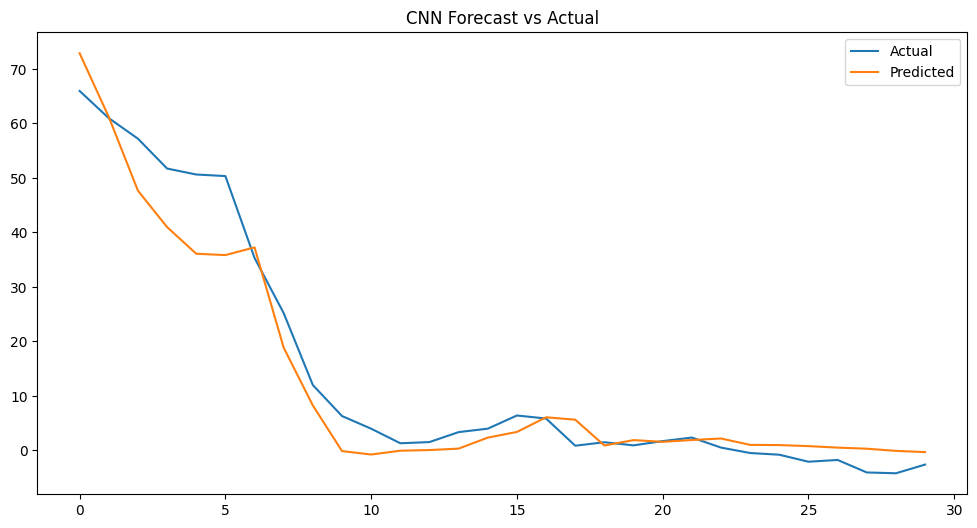

In [24]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown


# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()


# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 8  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 8), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




## 9

In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown



# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()



# Display column names
df.columns
df
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)
df
! pip install optuna
!pip install optuna
!pip install scikit-learn
!pip install tensorflow


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Rename for ease if necessary
target_column ="Inflation" # e.g., "Inflation"

# Normalize the data
scaler = MinMaxScaler()
df[target_column] = scaler.fit_transform(df[[target_column]])

# Convert to supervised learning format
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Define window size
window_size = 9  # Monthly data (1 year of past data to predict next month)  #################################################################

# Prepare input/output
X, y = create_sequences(df[target_column].values, window_size)

split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for CNN [samples, time steps, features]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

import optuna
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def create_model(trial, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=trial.suggest_int('filters', 32, 128),
                     kernel_size=trial.suggest_int('kernel_size', 1, 9), #################################################################
                     activation='relu',
                     input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
                  loss='mse')
    return model

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        model = create_model(trial, input_shape=X_train.shape[1:])
        model.fit(X_t, y_t, epochs=trial.suggest_int('epochs', 10, 50), verbose=0, batch_size=trial.suggest_categorical('batch_size', [8, 16, 32]))

        val_loss = model.evaluate(X_v, y_v, verbose=0)
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:', study.best_trial.params)

# Train final model
best_params = study.best_trial.params
model = Sequential()
model.add(Conv1D(filters=best_params['filters'],
                 kernel_size=best_params['kernel_size'],
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='mse')

model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, y_pred_inv)

# Print results
print(f" Test MSE  : {mse:.4f}")
print(f" Test RMSE : {rmse:.4f}")
print(f" Test MAE  : {mae:.4f}")
print(f" Test MAPE : {mape:.2f}%")
print(f" Test R²   : {r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('CNN Forecast vs Actual')
plt.legend()
plt.show()




Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 21.4MB/s]


            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


[I 2025-06-02 13:11:09,005] A new study created in memory with name: no-name-232de6ca-eab7-48f1-9309-fa78aa41ed4f
[I 2025-06-02 13:11:12,636] Trial 0 finished with value: 0.00616733751182134 and parameters: {'filters': 45, 'kernel_size': 1, 'lr': 0.0027672900286196973, 'epochs': 10, 'batch_size': 32}. Best is trial 0 with value: 0.00616733751182134.
[I 2025-06-02 13:11:23,351] Trial 1 finished with value: 0.0010656918263218056 and parameters: {'filters': 114, 'kernel_size': 1, 'lr': 0.0009342094698919399, 'epochs': 46, 'batch_size': 8}. Best is trial 1 with value: 0.0010656918263218056.
[I 2025-06-02 13:11:29,657] Trial 2 finished with value: 0.006064694103163977 and parameters: {'filters': 74, 'kernel_size': 5, 'lr': 0.0008625457626081811, 'epochs': 26, 'batch_size': 32}. Best is trial 1 with value: 0.0010656918263218056.
[I 2025-06-02 13:11:33,726] Trial 3 finished with value: 0.012323816423304379 and parameters: {'filters': 68, 'kernel_size': 6, 'lr': 0.00016098227049101172, 'epochs